# Loading the dataset

In [1]:
#!git clone https://gitlab.com/atlonxp/dog-breeds-classification.git
#%cd dog-breeds-classification

In [2]:
# Download datasets
!wget -q https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/dogImages.zip -O dogImages.zip
!wget -q https://gitlab.com/atlonxp/siit-deep-learning/-/raw/main/lfw.zip -O lfw.zip

In [3]:
# Unzip datasets
!unzip -qq dogImages.zip
!unzip -qq lfw.zip
!rm -rf __MACOSX/

# Install necessary packages

In [4]:
!pip -q install transformers
!pip -q install torchensemble
!pip -q install timm
!pip -q install evaluate
!pip -q install lion-pytorch
!pip -q install torchmetrics
!pip -q install torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.4 MB/s eta 0:00:00


In [5]:
import torch
from PIL import Image, ImageOps, ImageDraw
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch.nn as nn
import timm
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict
from torchmetrics import Accuracy
from torchsummary import summary
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from lion_pytorch import Lion
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
%matplotlib inline

# Overview of an Algorithm
- The task is to predict whether an image has Human or Dog, then, make a classification later
- so, we need 2 steps model, `detector` and `classifier`

# Detection with `DetectionTransformer (DETR)`

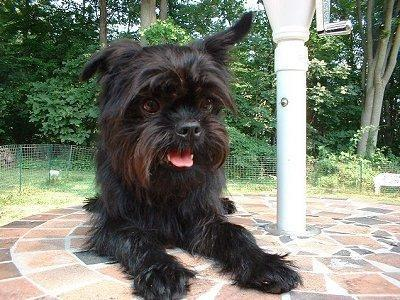

Detected dog with confidence 1.0 at location [76.0, 9.07, 301.63, 299.39]


In [6]:
# you can specify the revision tag if you don't want the timm dependency
sample_img = Image.open('/content/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

display(sample_img)

inputs = processor(images=sample_img, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([sample_img.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    prediction = model.config.id2label[label.item()]
    print(
            f"Detected {prediction} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

In [7]:
box

[76.0, 9.07, 301.63, 299.39]

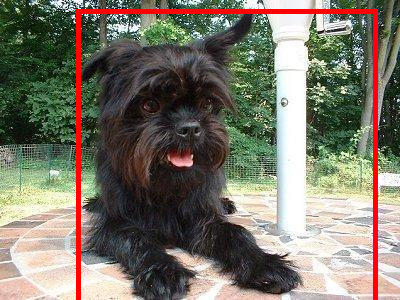

In [8]:
from google.colab.patches import cv2_imshow
# to crop an image
# Draw bounding boxes
og_img = Image.open('/content/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg')

draw = ImageDraw.Draw(og_img)

x, y, width, height = int(box[0]), int(box[1]), int(box[2]), int(box[3])
draw.rectangle([x, y, x + width, y + height], outline=(255, 0, 0), width=5)


display(og_img)
# Display the image with bounding boxes in Streamlit


# Construct a Data Class
- write a data class object in order to train the Classifier Model

In [9]:
# check for an error
def check_corrupted_image(img_path: str)->bool:
  try:
    img = Image.open(img_path)
    return False
  except OSError:
    return True

In [10]:
for img_path in glob.glob(f'/content/dogImages/train/*/*'):
  check = check_corrupted_image(img_path)
  if check:
    print(f"corrupted image at {img_path}")
  else:
    pass

In [11]:
# path checking in file directory
# count data in each fold in each categories

def get_total_class()->Tuple[Dict, Dict]:
  # to return label2idx and idx2label in order to match simplt with number for preds
  c = 0
  tot_classes = {}
  for img_path in glob.glob(f'/content/dogImages/train/*/*'):
    # to get breed type and remove number out from breed name
    breed_type = img_path.split('/')[-2][4:]
    if breed_type not in tot_classes.keys():
      tot_classes[breed_type] = c
      c += 1

  # convert the label back
  reverse_tot_classes = {v:k for k, v in tot_classes.items()}
  return (tot_classes, reverse_tot_classes)



def visualize_breed_fold(fold: str)->Dict:
  count_stats = {}
  for img_path in glob.glob(f'/content/dogImages/{fold}/*/*'):
    # to get breed type and remove number out from breed name
    breed_type = img_path.split('/')[-2][4:]
    if breed_type not in count_stats.keys():
      count_stats[breed_type] = 1
    else:
      count_stats[breed_type] += 1

  return count_stats


In [12]:
label2idx, idx2label = get_total_class()
print(label2idx)
print(idx2label)

{'Xoloitzcuintli': 0, 'Afghan_hound': 1, 'Cairn_terrier': 2, 'German_pinscher': 3, 'American_staffordshire_terrier': 4, 'Clumber_spaniel': 5, 'French_bulldog': 6, 'Norwich_terrier': 7, 'Belgian_tervuren': 8, 'Poodle': 9, 'Canaan_dog': 10, 'Alaskan_malamute': 11, 'American_water_spaniel': 12, 'Border_collie': 13, 'Irish_water_spaniel': 14, 'Smooth_fox_terrier': 15, 'Entlebucher_mountain_dog': 16, 'Boxer': 17, 'Keeshond': 18, 'Boston_terrier': 19, 'Plott': 20, 'Giant_schnauzer': 21, 'German_shorthaired_pointer': 22, 'Norwegian_lundehund': 23, 'Chinese_crested': 24, 'Borzoi': 25, 'English_setter': 26, 'Beagle': 27, 'Dalmatian': 28, 'Great_dane': 29, 'Cocker_spaniel': 30, 'Greyhound': 31, 'English_cocker_spaniel': 32, 'Kerry_blue_terrier': 33, 'Norwegian_buhund': 34, 'Silky_terrier': 35, 'Bearded_collie': 36, 'Bedlington_terrier': 37, 'Australian_shepherd': 38, 'Bloodhound': 39, 'Belgian_malinois': 40, 'Cane_corso': 41, 'Golden_retriever': 42, 'Otterhound': 43, 'Pekingese': 44, 'Norfolk_te

In [13]:
# test for visualization
print(visualize_breed_fold('train'))
print(visualize_breed_fold('valid'))
print(visualize_breed_fold('test'))

{'Xoloitzcuintli': 26, 'Afghan_hound': 58, 'Cairn_terrier': 63, 'German_pinscher': 47, 'American_staffordshire_terrier': 66, 'Clumber_spaniel': 49, 'French_bulldog': 51, 'Norwich_terrier': 44, 'Belgian_tervuren': 47, 'Poodle': 50, 'Canaan_dog': 50, 'Alaskan_malamute': 77, 'American_water_spaniel': 34, 'Border_collie': 74, 'Irish_water_spaniel': 51, 'Smooth_fox_terrier': 30, 'Entlebucher_mountain_dog': 42, 'Boxer': 64, 'Keeshond': 44, 'Boston_terrier': 65, 'Plott': 28, 'Giant_schnauzer': 41, 'German_shorthaired_pointer': 48, 'Norwegian_lundehund': 33, 'Chinese_crested': 50, 'Borzoi': 56, 'English_setter': 53, 'Beagle': 59, 'Dalmatian': 71, 'Great_dane': 40, 'Cocker_spaniel': 47, 'Greyhound': 56, 'English_cocker_spaniel': 61, 'Kerry_blue_terrier': 35, 'Norwegian_buhund': 26, 'Silky_terrier': 41, 'Bearded_collie': 62, 'Bedlington_terrier': 48, 'Australian_shepherd': 66, 'Bloodhound': 64, 'Belgian_malinois': 62, 'Cane_corso': 64, 'Golden_retriever': 64, 'Otterhound': 35, 'Pekingese': 48, '

In [14]:
# do the image transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    #transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor(),          # Convert to tensor
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),          # Convert to tensor
])


In [15]:
# construct a custom dataset to pass it through dataloader
class DogDataset(Dataset):
  def __init__(self,
               dir_path: str,
               fold: str,
               transform=None, # this need to part transform object in torchvision
               ):
    self.path = list(glob.glob(f'{dir_path}/{fold}/*/*'))
    self.transform = transform
    self.label2idx, self.idx2label = get_total_class()

  def load_image(self, index: int) -> Image.Image:
    '''Opens an image via a path and returns it.'''
    image_path = self.path[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.path)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    '''Returns one sample of data, data and label (X, y).'''
    img = self.load_image(index)
    class_name = self.path[index].split('/')[-2][4:]  # to get a class names
    class_idx = self.label2idx[class_name] # get a class index by mapping with the dictionary

    # transform if necessary
    # in case that our transform function is not None
    if self.transform:
      # transform an image
      transformed_image = self.transform(img)
      return transformed_image, class_idx # return data, label (X, y)
    else:
      return img, class_idx # returned untransformed image and label


In [16]:
# prepare a dataobject before pass it to dataloader
data_dir = '/content/dogImages'

train_data = DogDataset(data_dir, fold='train', transform=train_transform)
validation_data = DogDataset(data_dir, fold='valid', transform=test_transform)
test_data = DogDataset(data_dir, fold='test', transform=test_transform)

In [17]:
print(train_data.__len__())
print(validation_data.__len__())
print(test_data.__len__())

6680
835
836


# Load the CustomDataset into `DataLoader`

In [18]:
BATCH_SIZE = 256

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=validation_data,
    batch_size=BATCH_SIZE,
    shuffle=False # we are not gonna shuffle the test data
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # we are not gonna shuffle the test data
)


In [19]:
img_custom, label_custom = next(iter(train_dataloader))
img_custom.shape, label_custom.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

# Building `Convolutional Autoencoder (CVAE)` Model

In [61]:
# Define the autoencoder architecture
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#  # construct training argument object before pass to the model to be trained
# # class TrainingArguments:
# #     def __init__(self, output_dir, per_device_train_batch_size, num_train_epochs, logging_dir, save_steps):
# #         self.output_dir = output_dir
# #         self.per_device_train_batch_size = per_device_train_batch_size
# #         self.num_train_epochs = num_train_epochs
# #         self.logging_dir = logging_dir
# #         self.save_steps = save_steps

In [62]:
# Initialize the autoencoder
cvae = ConvolutionalAutoencoder()

# Train `CVAE` Model
- we will train in in 2 mode
    - 32bit precision (default)
    - 16bit precision (mixed precision - faster/ smaller memory consumption)

In [63]:
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
cvae.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

cuda


In [64]:
# check data type to observe the training mode in the precision format
for name, param in cvae.named_parameters():
    print(f"Parameter {name}: {param.dtype}")

Parameter encoder.0.weight: torch.float32
Parameter encoder.0.bias: torch.float32
Parameter encoder.3.weight: torch.float32
Parameter encoder.3.bias: torch.float32
Parameter decoder.0.weight: torch.float32
Parameter decoder.0.bias: torch.float32
Parameter decoder.2.weight: torch.float32
Parameter decoder.2.bias: torch.float32


In [65]:
torch.manual_seed(42)

epochs = 30

# in cvae, we will mind on reconstruction loss
best_loss = float('inf') # the lower the better
best_epoch = ""

# keep track of accuracy and loss of both train and val
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch+1}")
  train_loss = 0
  cvae.train()
  # loop through data batches
  try:
    for batch, (train_images, train_labels) in enumerate(train_dataloader):
      # always note that the batch size of the last batch may not fully fit the batch we specify since data
      # may not match the shape of power of 2
      #print(f"training on {batch*len(train_images)} from {len(train_dataloader)*BATCH_SIZE} images")
      # put data onto device
      train_images, _ = train_images.to(device), train_labels.to(device)

      # forward pass
      logits = cvae(train_images)

      # calculate loss (for reconstruction loss, label will be an original image)
      loss = criterion(logits, train_images)
      train_loss += loss

      # optimizer zero grad
      optimizer.zero_grad()

      # loss backward (backpropagation)
      loss.backward()

      # optimizer step (grad desc)
      optimizer.step()
    # finding an average loss and accuray of each epoch
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    # save the loss and acc of each epoch
    train_loss_list.append(train_loss)
  except OSError:
    pass

  # testing loop
  cvae.eval()
  val_loss, val_acc = 0, 0
  with torch.inference_mode():
    for val_images, val_labels in val_dataloader:
      # put data onto device
      val_images, _ = val_images.to(device), val_labels.to(device)

      val_logits = cvae(val_images)
      val_loss += criterion(val_logits, val_images)

  val_loss = val_loss / len(val_dataloader)
  val_loss_list.append(val_loss)

  # keep report when the best model appeared
  print('----------')
  if (val_loss < best_loss):
    best_loss = val_loss
    best_epoch = str(epoch+1)
    print(f"Best Model Saved!")

  print(f'train_reconstruction_loss: {train_loss:.2f} | val_reconstruction_loss {val_loss:.2f}')
  print('----------')

print("Training Result:")
print(f"Best Model is at epoch {best_epoch} -> val_reconstruction_loss: {best_loss:.2f}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
----------
Best Model Saved!
train_reconstruction_loss: 1.42 | val_reconstruction_loss 0.07
----------
Epoch: 2
----------
train_reconstruction_loss: 1.69 | val_reconstruction_loss 0.07
----------
Epoch: 3
----------
train_reconstruction_loss: 0.42 | val_reconstruction_loss 0.07
----------
Epoch: 4
----------
train_reconstruction_loss: 0.92 | val_reconstruction_loss 0.07
----------
Epoch: 5
----------
train_reconstruction_loss: 1.69 | val_reconstruction_loss 0.07
----------
Epoch: 6
----------
train_reconstruction_loss: 1.06 | val_reconstruction_loss 0.07
----------
Epoch: 7
----------
train_reconstruction_loss: 1.62 | val_reconstruction_loss 0.07
----------
Epoch: 8


KeyboardInterrupt: ignored

In [66]:
# observe how cvae transform image into compressed feature
# in latent space(image compression)


for image, label in test_dataloader:
  print('image shape input', image.shape)
  output = cvae.encoder(image.to(device))
  print('feature extracted shape', output.shape)
  break

image shape input torch.Size([256, 3, 224, 224])
feature extracted shape torch.Size([256, 8, 56, 56])


In [67]:
class CAEncoderClassifier(nn.Module):
  '''An integration of Model with trained encoder from CVAE'''
  def __init__(self,
               hidden_units: int,
               output_shape: int,
               encoder: nn.Sequential
               ):

    super().__init__()
    self.cvae_encoder = encoder # this is for trained encoder (cvae)
    self.classifier = nn.Sequential(
        nn.Flatten(), # reshape it into shape of vectors
        nn.Linear(in_features=hidden_units*56*56, out_features=256),
        nn.Linear(in_features=256, out_features=256),
        nn.Linear(in_features=256, out_features=128),
        nn.Linear(in_features=128, out_features=64),
        nn.Linear(in_features=64, out_features=32),
        nn.Linear(in_features=32, out_features=output_shape)

    )

  def forward(self, x:torch.Tensor)->torch.Tensor:
    compressed = self.cvae_encoder(x)
    logits = self.classifier(compressed)
    return logits


In [68]:
classifier = CAEncoderClassifier(8, len(label2idx), cvae.encoder)

In [71]:
# # how the flow is, in form of convert from logits to predictions
# for image, label in test_dataloader:
#   print('image shape input', image.shape)
#   output = classifier(image.to(device))
#   print('feature extracted shape', output.shape)
#   print(output)
#   probs = torch.softmax(output, dim=1)
#   print('probs', probs)
#   preds = torch.argmax(probs, dim=1)
#   print(preds)
#   print(preds.shape)
#   break

image shape input torch.Size([256, 3, 224, 224])


RuntimeError: ignored

# Train `CVAEncoderClassifier`
- we will train the model in form of 16bits precision

In [72]:
# prepare component
classifier = classifier.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=classifier.parameters(),
                            lr=1e-5)
accuracy = Accuracy(task="multiclass", num_classes=len(label2idx)).to(device)

In [ ]:
# write a training loop
# we will keep loss of the best model
from tqdm.auto import tqdm

epochs = 1000

best_loss = float('inf') # the lower the better
best_acc = float('-inf') # the higher the better
best_epoch = ""

# keep track of accuracy and loss of both train and val
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch+1}")
  train_loss, train_acc = 0, 0
  classifier.train()
  # loop through data batches
  try:
    for batch, (train_images, train_labels) in enumerate(train_dataloader):
      # always note that the batch size of the last batch may not fully fit the batch we specify since data
      # may not match the shape of power of 2
      # print(f"training on {batch*len(train_images)} from {len(train_dataloader)*BATCH_SIZE} images")
      # put data onto device
      train_images, train_labels = train_images.to(device), train_labels.to(device)

      # forward pass
      logits = classifier(train_images)

      # calculate loss
      loss = loss_fn(logits, train_labels)
      acc = accuracy(torch.softmax(logits, dim=1).argmax(dim=1), train_labels)
      train_loss += loss
      train_acc += acc

      # optimizer zero grad
      optimizer.zero_grad()

      # loss backward (backpropagation)
      loss.backward()

      # optimizer step (grad desc)
      optimizer.step()
    # finding an average loss and accuray of each epoch
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    # save the loss and acc of each epoch
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
  except OSError:
    pass

  # testing loop
  classifier.eval()
  val_loss, val_acc = 0, 0
  with torch.inference_mode():
    for val_images, val_labels in val_dataloader:
      # put data onto device
      val_images, val_labels = val_images.to(device), val_labels.to(device)

      val_logits = classifier(val_images)
      val_loss += loss_fn(val_logits, val_labels)
      val_acc += accuracy(torch.softmax(val_logits, dim=1).argmax(dim=1), val_labels)

  val_loss = val_loss / len(val_dataloader)
  val_acc = val_acc / len(val_dataloader)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)

  # keep report when the best model appeared
  print('----------')
  if (val_loss < best_loss) and (val_acc > best_acc):
    best_loss = val_loss
    best_acc = val_acc
    best_epoch = str(epoch+1)
    print(f"Best Model Saved!")

  print(f'train_loss: {train_loss:.2f} | train_acc: {train_acc:.2f} | val_loss {val_loss:.2f} | val_acc {val_acc:.2f}')
  print('----------')

print("Training Result:")
print(f"Best Model is at epoch {best_epoch} -> val_loss: {best_loss:.2f} | val_acc: {best_acc:.2f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1
----------
Best Model Saved!
train_loss: 102.39 | train_acc: 0.19 | val_loss 4.87 | val_acc 0.03
----------
Epoch: 2
----------
train_loss: 82.89 | train_acc: 0.16 | val_loss 4.87 | val_acc 0.02
----------
Epoch: 3
----------
Best Model Saved!
train_loss: 97.45 | train_acc: 0.26 | val_loss 4.86 | val_acc 0.03
----------
Epoch: 4
----------
train_loss: 34.05 | train_acc: 0.09 | val_loss 4.86 | val_acc 0.03
----------
Epoch: 5
----------
train_loss: 63.20 | train_acc: 0.19 | val_loss 4.86 | val_acc 0.03
----------
Epoch: 6
----------
Best Model Saved!
train_loss: 82.67 | train_acc: 0.22 | val_loss 4.86 | val_acc 0.03
----------
Epoch: 7
----------
train_loss: 58.32 | train_acc: 0.16 | val_loss 4.85 | val_acc 0.03
----------
Epoch: 8
----------
train_loss: 24.28 | train_acc: 0.09 | val_loss 4.85 | val_acc 0.03
----------
Epoch: 9
----------
Best Model Saved!
train_loss: 24.27 | train_acc: 0.09 | val_loss 4.85 | val_acc 0.04
----------
Epoch: 10
